In [1]:
import numpy as np
import pandas as pd
from utils import misc
from utils.misc import get_attr
import matplotlib.pyplot as plt
import time
from tqdm.notebook import tqdm

from gym_env import TradingEnv

pd.set_option('mode.chained_assignment', None)

In [2]:
spy_df = pd.read_csv('datasets/price_series/SPY.csv')
spy_df = misc.clean_df(spy_df)
spy_df

,date,open,high,low,close,adjclose,volume,ticker
0,1993-01-29,43.968750,43.968750,43.750000,43.937500,25.218206,1003200,SPY
1,1993-02-01,43.968750,44.250000,43.968750,44.250000,25.397572,480500,SPY
2,1993-02-02,44.218750,44.375000,44.125000,44.343750,25.451397,201300,SPY
3,1993-02-03,44.406250,44.843750,44.375000,44.812500,25.720430,529400,SPY
4,1993-02-04,44.968750,45.093750,44.468750,45.000000,25.828049,531500,SPY
...,...,...,...,...,...,...,...,...
7581,2023-03-09,399.739990,401.480011,390.529999,391.559998,391.559998,111945300,SPY
7582,2023-03-10,390.989990,393.160004,384.320007,385.910004,385.910004,189105300,SPY
7583,2023-03-13,381.809998,390.390015,380.649994,385.359985,385.359985,157790000,SPY
7584,2023-03-14,390.500000,393.450012,387.049988,391.730011,391.730011,149752400,SPY


In [3]:
def ma_signal(df, **kwargs):
    
    short_period = get_attr(kwargs, 'short_period', 10)
    long_period = get_attr(kwargs, 'long_period', 20)

    df['signal'] = df['adjclose'].rolling(short_period).mean() - df['adjclose'].rolling(long_period).mean()
    df['signal+1'] = df['signal'].shift(1)
    df = df.dropna()

    return df



df = spy_df.copy()
df['signal'] = df['adjclose'].rolling(10).mean() - df['adjclose'].rolling(20).mean()
df['signal+1'] = df['signal'].shift(1)
df['returns'] = np.insert(df['close'].to_numpy()[1:] / df['close'].to_numpy()[:-1], 1, 0) - 1
df['volatility'] = df['returns'].rolling(30).std()

df = df.dropna()
df



,date,open,high,low,close,adjclose,volume,ticker,signal,signal+1,returns,volatility
29,1993-03-12,45.187500,45.218750,44.812500,45.093750,25.881849,643600,SPY,0.366797,0.331822,-0.010288,0.182937
30,1993-03-15,45.062500,45.312500,45.062500,45.312500,26.007406,310800,SPY,0.405359,0.366797,0.004851,0.182920
31,1993-03-16,45.312500,45.437500,45.312500,45.312500,26.007406,30800,SPY,0.373969,0.405359,0.000000,0.008342
32,1993-03-17,45.250000,45.250000,44.968750,45.031250,25.845985,21800,SPY,0.322851,0.373969,-0.006207,0.008435
33,1993-03-18,45.218750,45.500000,45.218750,45.312500,26.007406,59300,SPY,0.293255,0.322851,0.006246,0.008294
...,...,...,...,...,...,...,...,...,...,...,...,...
7581,2023-03-09,399.739990,401.480011,390.529999,391.559998,391.559998,111945300,SPY,-4.404001,-4.448500,-0.018450,0.010437
7582,2023-03-10,390.989990,393.160004,384.320007,385.910004,385.910004,189105300,SPY,-4.392001,-4.404001,-0.014429,0.010488
7583,2023-03-13,381.809998,390.390015,380.649994,385.359985,385.359985,157790000,SPY,-4.495003,-4.392001,-0.001425,0.010463
7584,2023-03-14,390.500000,393.450012,387.049988,391.730011,391.730011,149752400,SPY,-3.893004,-4.495003,0.016530,0.010763


In [4]:
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [5]:
from agent import DQNagent

In [6]:
class DQN(nn.Module):
    
    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)
    

  0%|          | 0/10 [00:00<?, ?it/s]

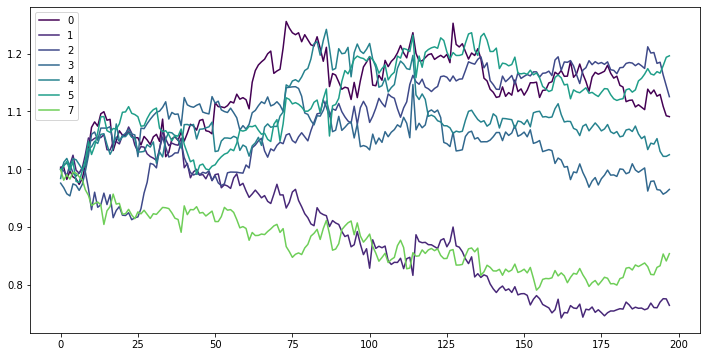

In [8]:
input_feature_list = [
    'open',
    'high',
    'low',
    'close',
    'adjclose',
    'volume',
    'volatility',
    'signal',
    'signal+1',   
]

trader_state_list = [
    'cash',
    'position',
    'position_value',
    'portfolio_value',
    # 'leverage',
    # 'portfolio_volatility',
]

params = {
    'action_size': 9,
    'state_size': len(input_feature_list) + len(trader_state_list),
    'epsilon': 1.0,
    'epsilon_decay': 0.9995,
    'epsilon_min': 0.01,
    'replay_memory_size': 100000,
    'batch_size': 200,
    'gamma': 0.99,
    # env_params
    'initial_capital': 1000000,
    'lookback_period': 20,
    'lookforward_period': 20,
    'render_window_size': 10,
}


        

df = df[-200:]
env = TradingEnv(df=df, input_feature_list=input_feature_list, **params)

import torch.optim as optim

agent = DQNagent(DQN, **params)

# Set up the optimizer
optimizer = optim.Adam(agent.dqn.parameters(), lr=0.001)

# Run the environment for one episode
state = env.reset()
done = False


plt.figure(figsize=(12, 6))
episode = 0
action_list = []
num_episodes = 10
batch_size = 200
colors = plt.cm.viridis(np.linspace(0, 1, num_episodes))
for episode in tqdm(range(num_episodes)):
    total_reward = 0
    while not done:

        # Select an action using the DQN agent
        action1, action2 = agent.select_action(state)

        
        
        action_list.append((action1, action2))

        # Take the action in the environment
        next_state, reward, done, info = env.step([action1, action2])
        # if reward == 0: print(next_state, reward, done, info)

        # Add the experience to the replay memory
        agent.memory.push(state, [action1, action2], next_state, reward, done)

        # Move to the next state
        state = next_state
        total_reward += reward

        # Update the DQN agent
        if len(agent.memory) > batch_size:
            agent.learn(optimizer)
    
    # Print the total reward for the episode
    # print("Episode {}: Total reward = {}".format(episode, total_reward))

        # Update the target network every 10 episodes
    
    if episode % 6 == 0:
        agent.update_target_network()
    if episode <= 5 or episode % 7 == 0:
        plt.plot(env.records['portfolio_return'], label=episode, color=colors[episode])
    state = env.reset()
    done = False


plt.legend()
plt.show()
